# Figure S8. Robustness of the findings to the effect of inter-individual variability of structural connectome

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.stats.multitest
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
    "micamics": os.path.join(os.environ["PROJECT_DIR"], "output", "micamics")
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)
from utils import transform, plot

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = '#44546A'
add_text = True # add statistics as text to some figures

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Load data:

In [15]:
parcels = transform.load_ordered_parcel_labels('schaefer-100')
all_stats = {}
all_ICCs_by_age = {}
all_data = {}
all_I_E = {}
for alt in ['main', 'sc_temp']:
    all_stats[alt] = pd.read_csv(f"p_pnc200_{alt}_IE_age_stats.csv", index_col=0)
    all_data[alt] = pd.read_csv(f"pnc200_{alt}_data.csv", index_col=0)
    all_I_E[alt] = pd.read_csv(f"pnc200_{alt}_IE.csv", index_col=0)
    if alt != 'main':
        all_ICCs_by_age[alt] = pd.read_csv(f"p_pnc200_{alt}_IE_icc.csv", index_col=0)

## A. Effect of age on E-I ratio controlled for SC strength

Calculate subject-specific SC strength maps:

In [9]:
sc_strength = pd.DataFrame(index=all_data['main'].index, columns=parcels, dtype=float)
for sub in tqdm(all_data['main'].index):
    sc = pd.read_csv(
        os.path.join(OUTPUT_DIR['pnc'], 'SC', sub, 
                     'ctx_parc-schaefer-100_mean001_thresh-1_desc-strength.csv.gz'),
        index_col=0)
    sc_strength.loc[sub, :] = sc.sum(axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 77.29it/s]


Calculate age effects while controlling for SC strength:

In [10]:
df = pd.concat([all_I_E['main'], sc_strength, all_data['main']], axis=1)
df.columns = [f'IE_{i}' for i in range(100)] + [f'SC_{i}' for i in range(100)] + list(df.columns[200:])
df['sex_int'] = (df['sex'] == 'F').astype('int')

t = pd.Series(index=parcels)
r = pd.Series(index=parcels)
p = pd.Series(index=parcels)
Ns = pd.Series(index=parcels)
outliers = {}
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = df.index[(scipy.stats.zscore(df.loc[:, f'IE_{i}']).abs() < 3)]
    outliers[parc] = set(df.index) - set(curr_subs)
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"IE_{i} ~ gof + sex + mean_rms + SC_{i}", data=model_df).fit()
    r.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the model
    mod = smf.ols(f'IE_{i} ~ age + gof + sex_int + mean_rms + SC_{i}', data=model_df)
    res = mod.fit()
    t.loc[parc] = res.tvalues['age']
    p.loc[parc] = res.pvalues['age']
    Ns.loc[parc] = len(curr_subs)

# FDR correction
_, p_fdr = statsmodels.stats.multitest.fdrcorrection(p)
p_fdr = pd.Series(p_fdr, index=parcels)

# display stats of signficant regions
stats_age_sc_conf = pd.DataFrame({"t": t, "r": r, "p": p, "p_fdr": p_fdr, "N": Ns})
stats_age_sc_conf.to_csv("p_pnc200_sc_conf_IE_age_stats.csv")
stats_age_sc_conf[stats_age_sc_conf["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr,N
7Networks_RH_Cont_Par_1,-4.350,-0.291,0.000,0.002,198.0
7Networks_RH_Cont_PFCl_1,-4.250,-0.290,0.000,0.002,198.0
7Networks_RH_DorsAttn_Post_3,-3.586,-0.250,0.000,0.011,197.0
7Networks_RH_Default_Par_1,-3.547,-0.238,0.000,0.011,199.0
7Networks_LH_Cont_pCun_1,-3.511,-0.244,0.001,0.011,199.0
7Networks_RH_DorsAttn_Post_1,-3.342,-0.232,0.001,0.015,200.0
7Networks_RH_Cont_PFCl_2,-3.329,-0.230,0.001,0.015,199.0
7Networks_RH_Default_PFCdPFCm_2,-3.095,-0.219,0.002,0.028,193.0
7Networks_LH_DorsAttn_Post_5,-3.011,-0.210,0.003,0.030,195.0
7Networks_RH_SalVentAttn_TempOccPar_1,-3.002,-0.211,0.003,0.030,198.0


### (i) FDR-significant effects

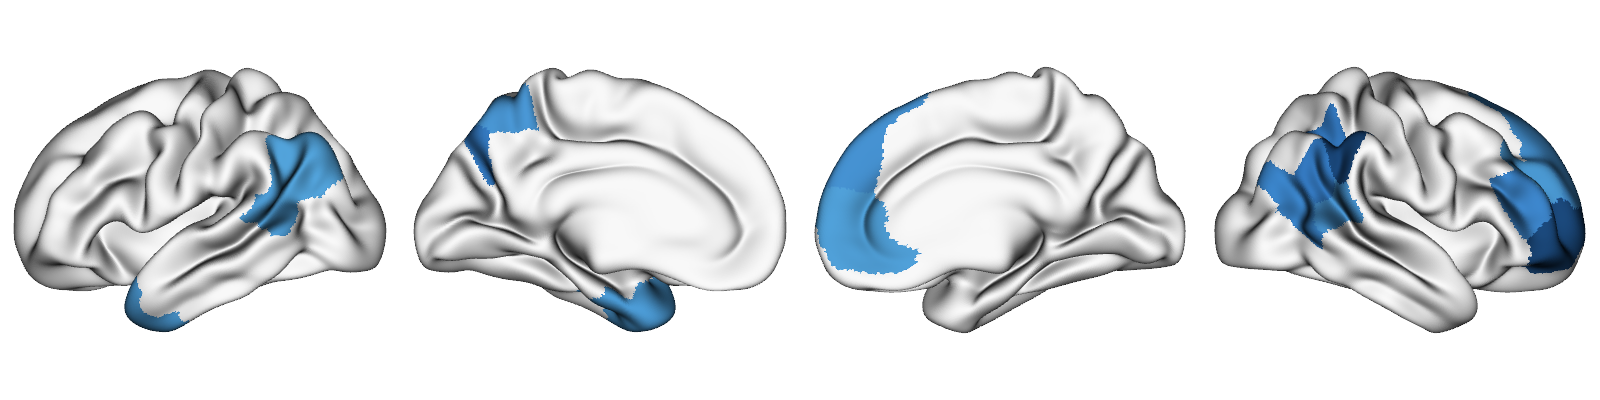

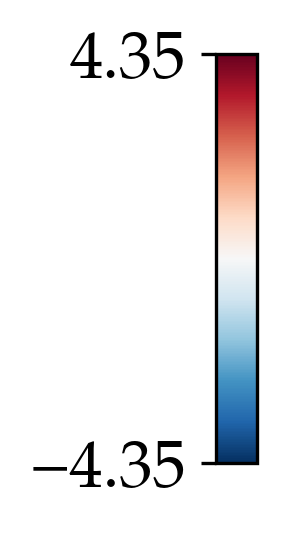

In [11]:
vmin = min(stats_age_sc_conf['t'].values.min(), -stats_age_sc_conf['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        stats_age_sc_conf['t'][stats_age_sc_conf['p_fdr']<0.05], 
        'schaefer-100', concat=True, space='fsaverage'
    ), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='row',
)

### (ii) Comparison with main age effect map

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.9600232656644795 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.9765640216823538 ; p-vlaue: 0.0


<Axes: xlabel='E-I ratio age effect\n(Controlled for SC)', ylabel='E-I ratio age effect\n(Not controlled for SC)'>

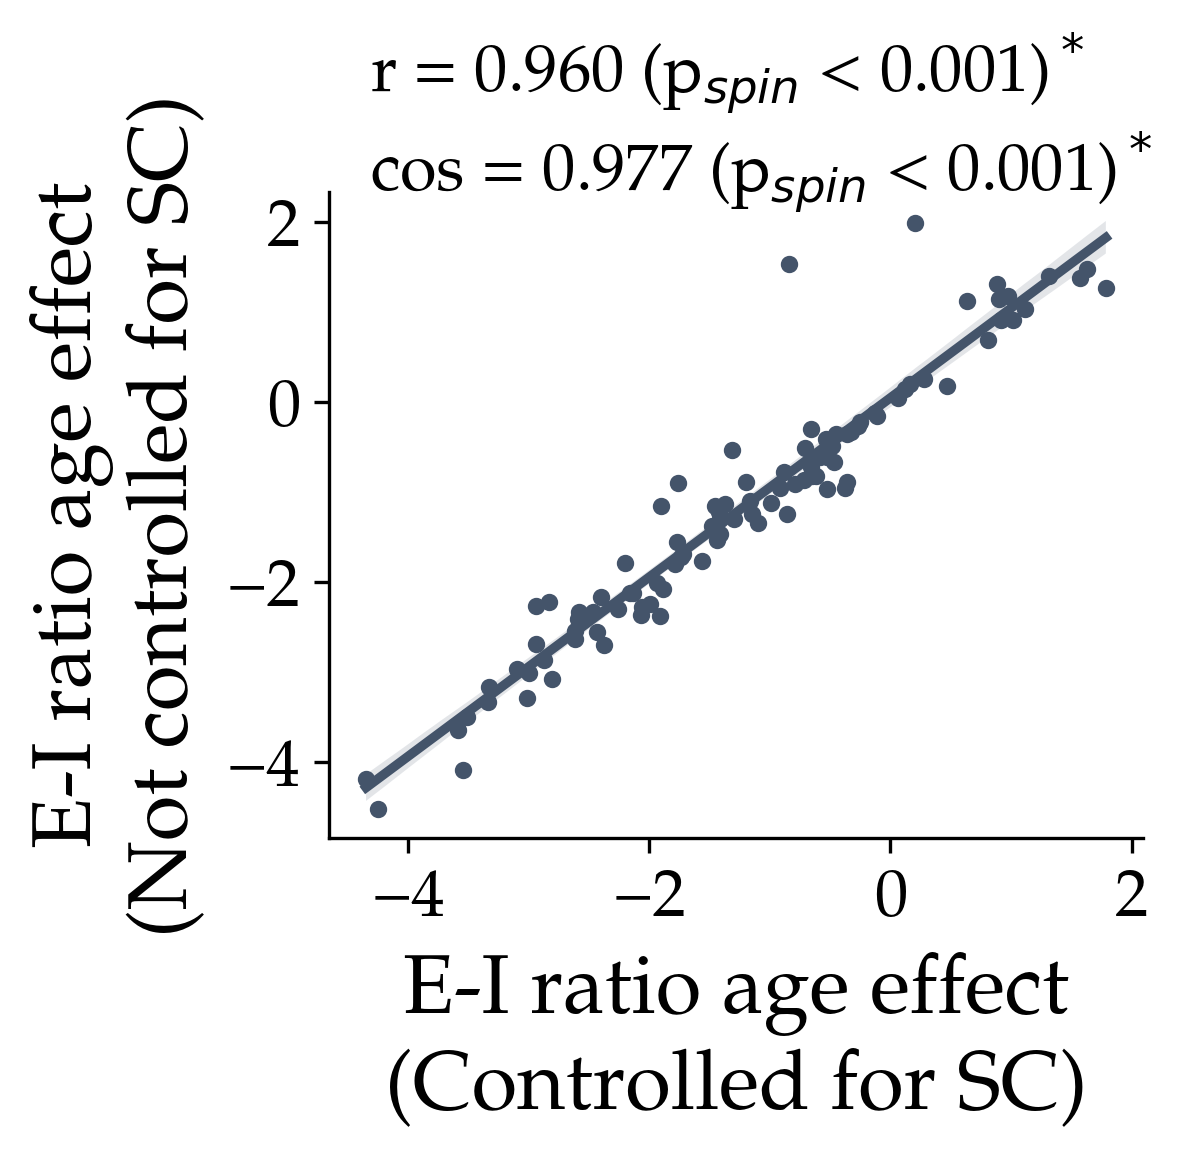

In [18]:
plot.reg_plot(
    stats_age_sc_conf[['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='E-I ratio age effect''\n(Controlled for SC)',
    ylabel='E-I ratio age effect''\n(Not controlled for SC)'
)

## B. Effect of age on E-I ratio using template SC

### (i) FDR-significant effects

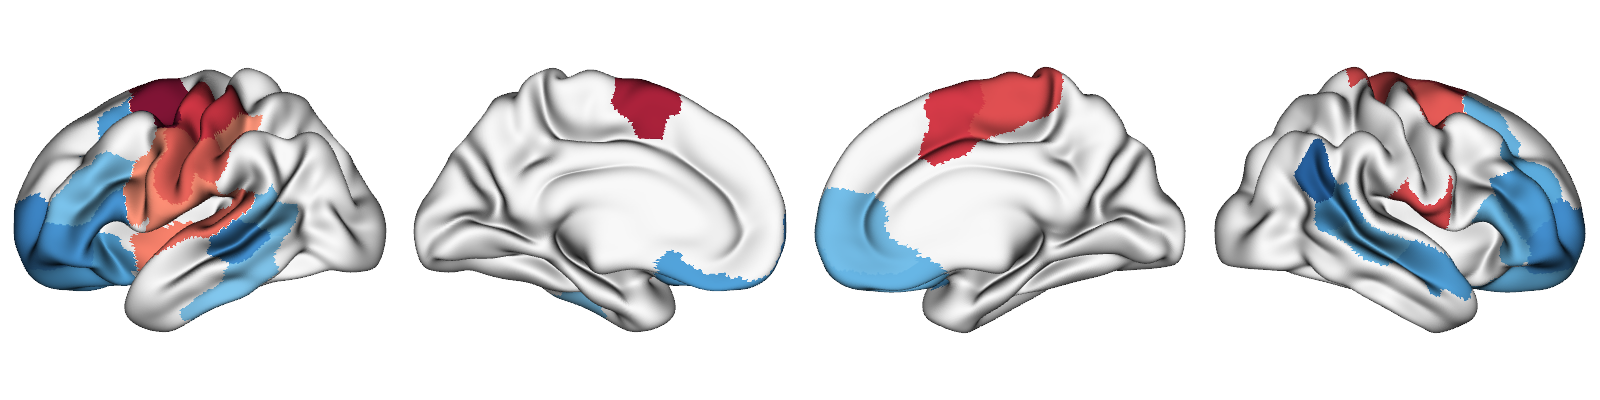

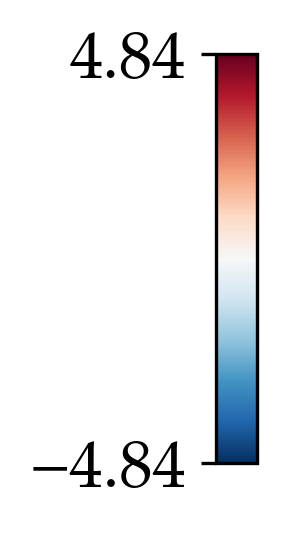

In [13]:
vmin = min(all_stats['sc_temp']['t'].values.min(), -all_stats['sc_temp']['t'].values.max()).round(2)
vmax = -vmin
plot.plot_surface(
    transform.deparcellate_surf(
        all_stats['sc_temp']['t'][all_stats['sc_temp']['p_fdr']<0.05], 
        'schaefer-100', concat=True, space='fsaverage'
    ), 
    'fsaverage', mesh_kind='semi-inflated',
    vrange=(vmin, vmax), cmap='RdBu_r', cbar=True,
    cbar_kwargs=dict(figsize=(2,2)),
    layout_style='row',
)

### (ii) Comparison with main age effect map

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Correlation coefficient: 0.4854542531701813 ; p-vlaue: 0.0
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
Cosine similarity: 0.43955812825591556 ; p-vlaue: 0.0


<Axes: xlabel='E-I ratio age effect\n(Template SC)', ylabel='E-I ratio age effect\n(Subject SC)'>

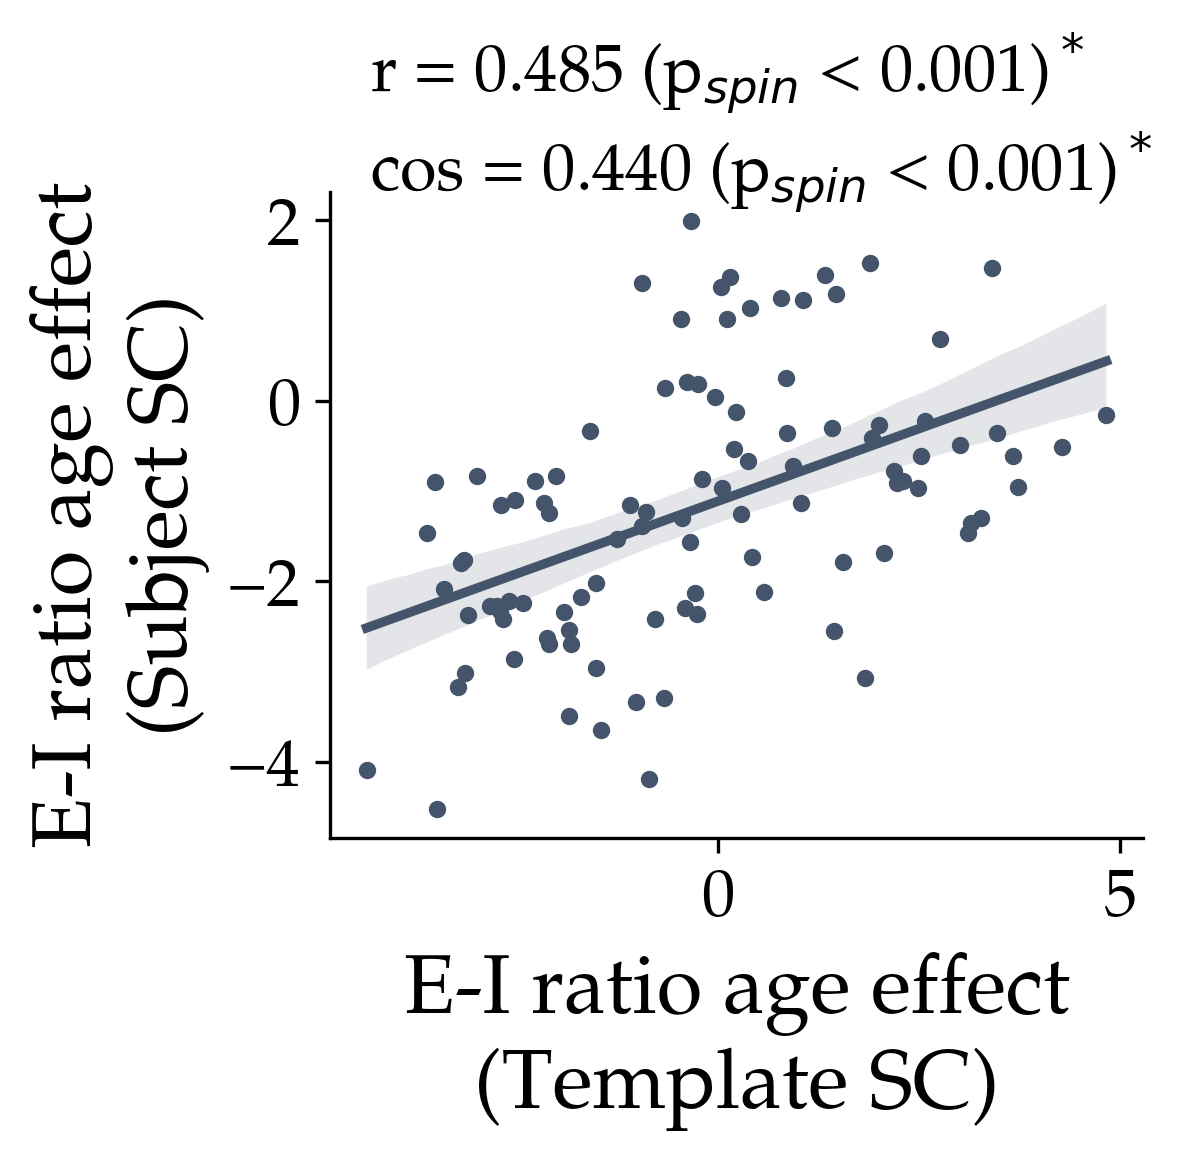

In [11]:
plot.reg_plot(
    all_stats['sc_temp'][['t']], all_stats['main'][['t']], 'schaefer-100',
    xlabel='E-I ratio age effect''\n(Template SC)',
    ylabel='E-I ratio age effect''\n(Subject SC)'
)

### (iii) ICC

       younger    older      all
count  100.000  100.000  100.000
mean     0.227    0.377    0.319
std      0.183    0.201    0.165
min     -0.353   -0.111   -0.179
25%      0.120    0.261    0.231
50%      0.250    0.411    0.335
75%      0.347    0.518    0.425
max      0.708    0.763    0.632
T =-7.458347286952439, p = 3.40411185915767e-11


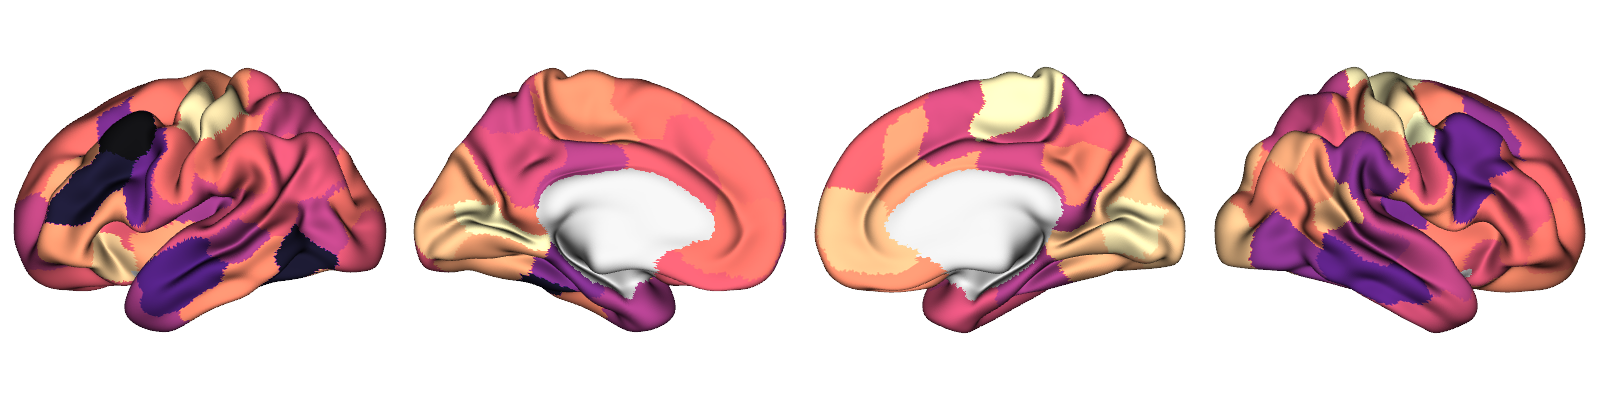

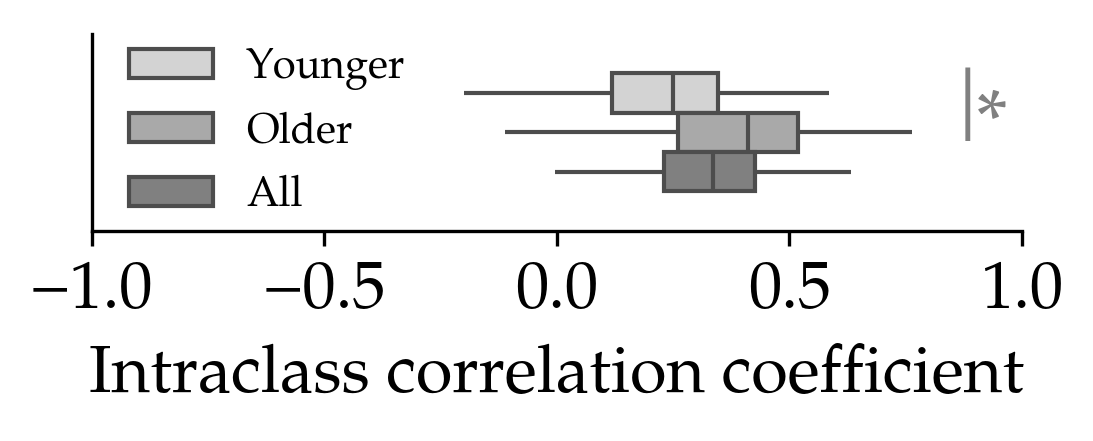

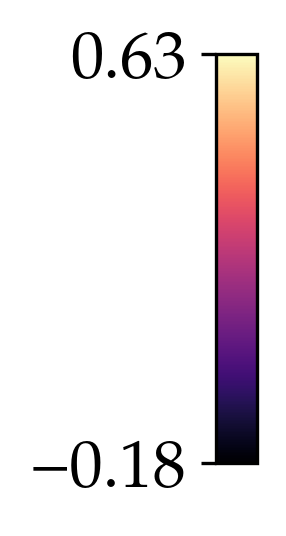

In [16]:
print(all_ICCs_by_age['sc_temp'].describe().round(3))
plot.plot_icc_by_age(all_ICCs_by_age['sc_temp'], 'schaefer-100')

### (iv) Comparison of GOF

In [17]:
gof_labels = {    
    'gof': 'Goodness-of-fit',
    'fc_corr': 'FC correlation',
    'sc_fc': 'SC-FC coupling',
    'fc_diff': 'FC difference',
    'fcd_ks': 'FCD KS distance',
}

Goodness-of-fit	-8.226	0.0	-0.068	0.117
FC correlation	-13.072	0.0	-0.047	0.051
SC-FC coupling	20.228	0.0	0.031	0.022
FC difference	-2.741	0.007	-0.015	0.076
FCD KS distance	6.302	0.0	0.036	0.08


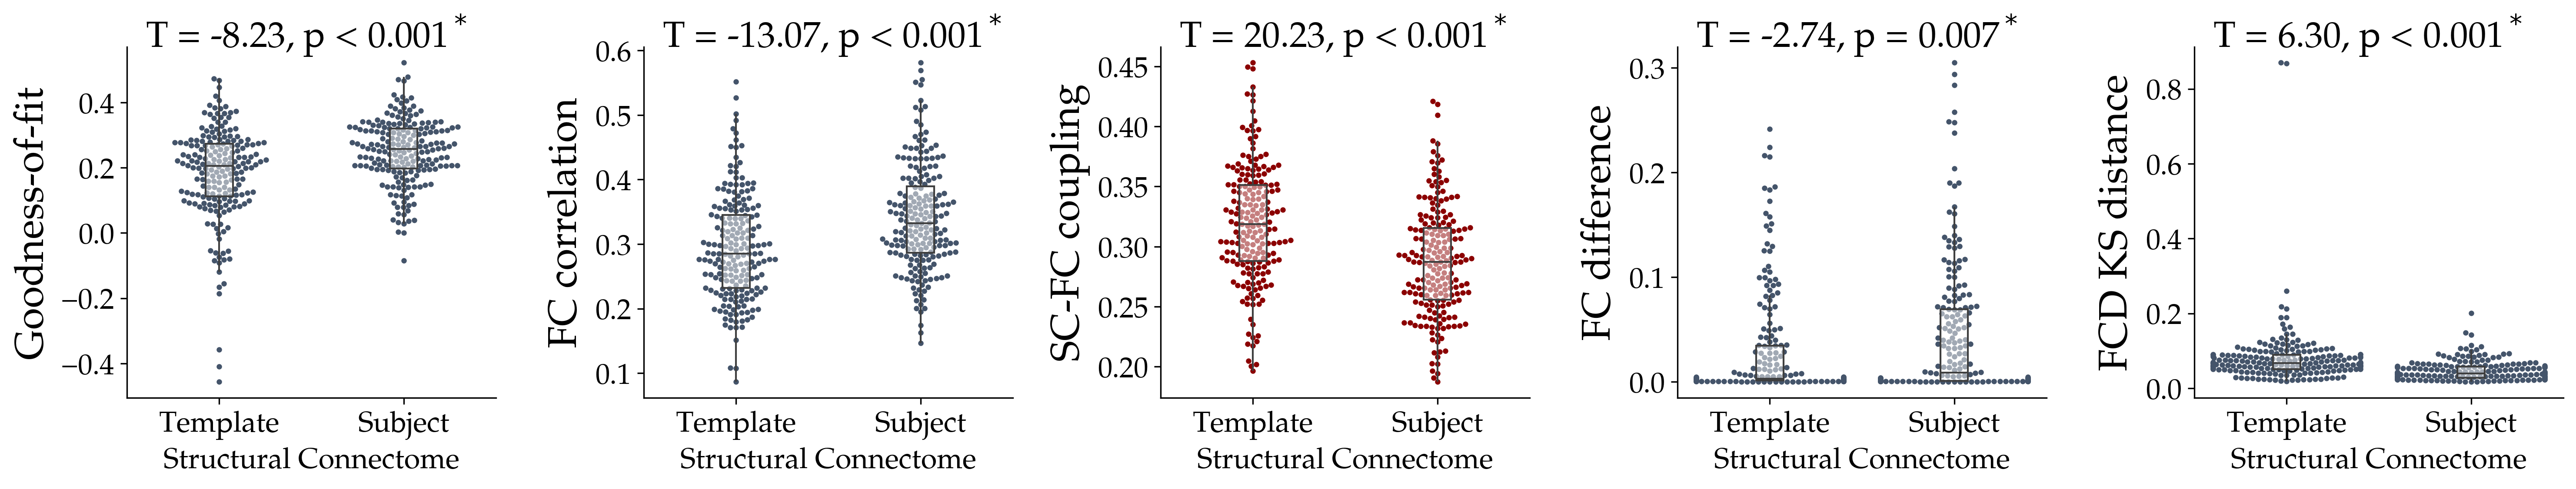

In [18]:
all_data['sc_temp']['SC'] = 'Template'
all_data['main']['SC'] = 'Subject'
data_combined = pd.concat([all_data['sc_temp'], all_data['main']], axis=0)
gof_measures = ['gof','fc_corr', 'sc_fc', 'fc_diff', 'fcd_ks']
fig, axd = plt.subplot_mosaic(
    [
        gof_measures,
    ],
    gridspec_kw=dict(width_ratios=[1]*5, height_ratios=[1]), 
    figsize=(20, 4)
)

for i, col in enumerate(gof_measures):
    label = gof_labels[col]
    ax = axd[col]
    if col == 'sc_fc':
        color = 'darkred'
    else:
        color= '#44546A'
    sns.swarmplot(
        data=data_combined,
        x='SC', y=col,
        s=3, color=color,
        ax=ax
    )
    sns.boxplot(
        data=data_combined,
        x='SC', y=col,
        showfliers=False,
        showcaps=False, width=0.15,
        boxprops={"facecolor": (1, 1, 1, 0.5)},
        ax=ax)
    plt.setp(ax.collections, zorder=0, label="") # puts swarm in the back
    ax.set_ylabel(label, fontsize=22)
    ax.set_xlabel('Structural Connectome')
    sns.despine()
    # add statistics
    alt = all_data['sc_temp'].loc[:, col]
    main = all_data['main'].loc[:, col]
    t, p = scipy.stats.ttest_rel(alt, main)
    if add_text:
        if p > 0.001:
            text = f'T = {t:.2f}, p = {p:.3f}'
        else:
            text = f'T = {t:.2f}, p < 0.001'
        if p < 0.05:
            text+=r'$^*$'
        text_x = ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.05
        text_y = ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*1
        ax.text(text_x, text_y, 
                text,
                color='black',
                size=20,
                multialignment='left')
    mean_diff = (alt - main).mean()
    sd_diff = (alt - main).std()
    print(label, round(t, 3), round(p,3), round(mean_diff,3), round(sd_diff,3), sep="\t")
fig.tight_layout(pad=1.0)